In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from scipy.stats import norm
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.cdf import get_cdf
from NCP.nn.losses import CMELoss
from NCP.utils import smooth_cdf
from NCP.metrics import hellinger, kullback_leibler, wasserstein1
from NCP.utils import frnp
import lightning as L
from NCP.nn.callbacks import LitProgressBar

from NCP.examples.tools.plot_utils import setup_plots, plot_expectation
from NCP.examples.tools.data_gen import gen_bimodal
setup_plots()

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

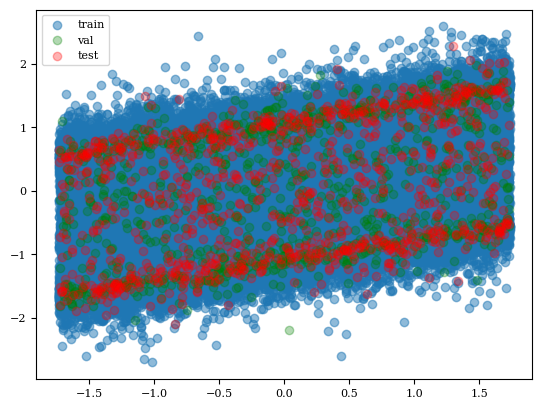

In [6]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_bimodal(0.5, 30, N_train=Ntrain, N_val=Nval, N_test=Ntest)

plt.scatter(X_train[:,0], Y_train, alpha=0.5)
plt.scatter(X_val[:,0], Y_val, color='green', alpha=0.3)
plt.scatter(X_test[:,0], Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [13]:
L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e3)

MLP_kwargs_U = {
    'input_shape': X_train.shape[-1],
    'output_shape': 10,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

MLP_kwargs_V = {
    'input_shape': Y_train.shape[-1],
    'output_shape': 10,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 38.5 K
--------------------------------------
38.5 K    Trainable params
0         Non-trainable params
38.5 K    Total params
0.154     Total estimated model params size (MB)


d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100% 1/1 [00:00<00:00,  1.59it/s]

In [ ]:
# todo: plot different cdfs, replicate plots from linCDE